## Question 1: Training a Light Score-Based Generative Model with Sliced Score Matching on MNIST

**Objective:** Implement and train a lightweight score-based generative model using the sliced score matching technique. The goal is to learn the data distribution's score for generating new samples similar to the training data.

**Dataset:** Use the MNIST dataset, which consists of 70,000 28x28 grayscale images of handwritten digits (0-9). It is divided into 60,000 training images and 10,000 test images. MNIST can be found at https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html To reduce computational complexity, you can downscale the MNIST images to 7x7. Both score models trained with 28x28 and with 7x7 MNIST will get full credits.

**Tasks:**
1. Data preparation: Normalize the MNIST images to have pixel values between -1 and 1.
2. Model Architecture: Construct a simple convolutional neural network (CNN) for estimating the data distribution's score. This network should accept a noisy image as input and output a score estimate.
3. Sliced Score Matching: Implement the sliced score matching objective. Add Gaussian noise to the input images, and train the model to approximate the score of the noise-perturbed data distribution.
4. Training: Use a smaller batch size if necessary to accommodate memory constraints. Train the model using a straightforward optimizer like Adam, with a conservative learning rate (e.g., 1e-3). Consider reducing the number of training epochs and implementing checkpointing to save the model intermittently.
5. Evaluation and Generation: Evaluate the model qualitatively by visual inspection of generated digits.

(A helpful website: https://github.com/mfkasim1/score-based-tutorial/blob/main/01-SGM-without-SDE.ipynb)

In [1]:
import matplotlib.pyplot as plt

In [2]:
""" Data Preparation """

from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

# Define a transform to normalize the data and apply basic augmentations
transform = transforms.Compose([
    transforms.Resize((8, 8)),  # Resize to 7x7
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05)),  # slight rotation and translation
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load the MNIST dataset
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

torch.Size([16, 1, 8, 8])


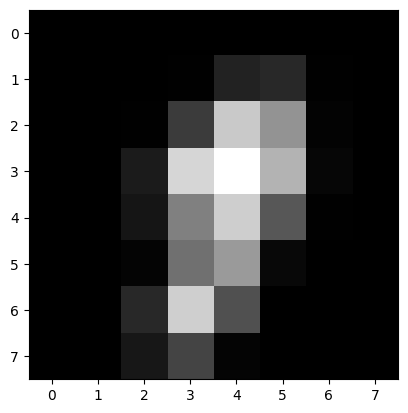

In [3]:
for img in train_loader:
    print(img[0].shape)
    plt.imshow(img[0][0].squeeze(0),cmap='gray')
    break

In [4]:
import torch.nn as nn
import torch
import torch.nn.functional as F
""" Model Architecture """
# score_network takes input of MNIST image dimension and returns the output of
# the same size, socre network usually follows the structure of U-Net
class scoreNet(nn.Module):
    def __init__(self):
        super().__init__()
        """YOUR CODE"""
        self.left1 = nn.Sequential(nn.Conv2d(1, 64, 3, padding=1), nn.ReLU(), nn.Conv2d(64, 64, 3, padding=1),nn.ReLU())
        self.left2 = nn.Sequential(nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.Conv2d(128, 128, 3, padding=1),nn.ReLU())
        self.lower = nn.Sequential(nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(), nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(), nn.ConvTranspose2d(256, 128, 2, stride=2))
        
        self.right1 = nn.Sequential(nn.Conv2d(128, 64, 3, padding=1), nn.ReLU(), nn.Conv2d(64, 64, 3, padding=1),nn.ReLU(),nn.Conv2d(64, 1, 3, padding=1))
        self.right2 = nn.Sequential(nn.Conv2d(256, 128, 3, padding=1), nn.ReLU(), nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(), nn.ConvTranspose2d(128, 64, 2, stride=2))


    def forward(self, x):
        x_dim = x.dim()
        if x_dim == 3:
            x=x.unsqueeze(0)
        left1 = self.left1(x)
        x = F.max_pool2d(left1, 2)
        left2 = self.left2(x)
        x = F.max_pool2d(left2, 2)
        lower = self.lower(x)
        up2 = torch.cat([left2, lower], dim = 1)
        up2 = self.right2(up2)
        up2 = torch.cat([left1, up2], dim = 1)
        res = self.right1(up2)
        if x_dim==3:
            res = res.squeeze(0)
        return res

model = scoreNet()
x = torch.randn(8, 1,  28, 28)
out = model(x)
print(out.shape)

torch.Size([8, 1, 28, 28])


In [5]:

from functorch import jacrev, vmap

def calc_loss(score_network: torch.nn.Module, x: torch.Tensor, debug=False) -> torch.Tensor:
    # x: (batch_size, 2) is the training data
    # x: [B, 1, H, W]
    score = score_network(x)  # score: (batch_size, 2)
    debug and print("score shape", score.shape)
    
    # first term: half of the squared norm
    v = torch.randn(x.shape).to(x.device)
    debug and print("v", v.shape)
    term1 = ((score * v)** 2).mean() * 0.5
    debug and print(term1)
    
    # second term: trace of the Jacobian
    jac = vmap(jacrev(score_network))(x)  # (batch_size, 2, 2)
    jac = jac.reshape(jac.shape[0], x.shape[-1]*x.shape[-1],x.shape[-1]*x.shape[-1] )
    debug and print("jac", jac.shape)
    v = v.reshape(v.size(0), v.size(-1)**2).unsqueeze(-1)
    debug and print("v", v.shape)
    term2 = torch.bmm(v.transpose(1,-1), jac)
    term2 = torch.bmm(term2, v).mean()
    return term1 + term2


# def calc_loss(score_network: torch.nn.Module, x: torch.Tensor) -> torch.Tensor:
#     # x: (batch_size, 2) is the training data
#     score = score_network(x)  # score: (b, 1, w, h)
#     score = score.reshape(score.size(0), -1)
    
#     # first term: half of the squared norm
#     term1 = torch.linalg.norm(score, dim=-1) ** 2 * 0.5
    
#     # second term: trace of the Jacobian
#     jac = vmap(jacrev(score_network))(x)  # (batch_size, 2, 2)
#     jac = jac.reshape(jac.shape[0], x.shape[-1]*x.shape[-1],x.shape[-1]*x.shape[-1] )
#     term2 = torch.einsum("bii->b", jac)  # compute the trace
#     return (term1 + term2).mean()

device="cuda:7"
score_network = scoreNet()
score_network.to(device)
x = torch.randn(16, 1, 8, 8).to(device)
calc_loss(score_network,x)

/DKUdata/tangbl/anaconda/envs/bltang_new/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  return F.conv2d(input, weight, bias, self.stride,
/DKUdata/tangbl/anaconda/envs/bltang_new/lib/python3.9/site-packages/torch/_functorch/deprecated.py:83: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.jacrev is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.jacrev instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('jacrev')
/DKUdata/tangbl/anaconda/envs/bltang_new/lib/python3.9/site-packages/torch/_functorch/deprecated.py:61: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, func

tensor(-0.0706, device='cuda:7', grad_fn=<AddBackward0>)

In [6]:
score_network = scoreNet()
opt = torch.optim.Adam(score_network.parameters(), lr=3e-4)
resume=""

if resume != "":
    print(f"loading model from {resume}")
    ckpt = torch.load(resume, map_location='cpu')
    score_network.load_state_dict(ckpt['model_state_dict'])
    opt.load_state_dict(ckpt['optim_state_dict'])
score_network.to(device);

In [9]:
"""Training"""
import time
import datetime
EPOCH=10
LOG_INTERVAL=100

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

start = time.time()
for i_epoch in range(EPOCH):
    total_loss = 0
    for i, data in enumerate(train_loader):
        opt.zero_grad()
        data[0] = data[0].to(device)

        # training step
        score_network.zero_grad()
        loss = calc_loss(score_network, data[0])
        loss.backward()
        opt.step()

        # running stats
        total_loss = total_loss + loss.detach().item()
        
        if i % LOG_INTERVAL == 0:
            print(f"[Epoch {i_epoch}] | [{i}|{len(train_loader)}] loss: {loss.item()}, avg loss: {total_loss/(i+1)} est epoch: {datetime.timedelta(seconds=(len(train_loader) -1 - i) / LOG_INTERVAL * (time.time() - start))}")
            start = time.time()
    torch.save({"model_state_dict": score_network.state_dict(), "optim_state_dict": opt.state_dict()}, f"epoch_{i_epoch}.pth")

[Epoch 0] | [0|235] loss: -202.37242126464844, avg loss: -202.37242126464844 est epoch: 0:00:02.424849
[Epoch 0] | [100|235] loss: -220.5964813232422, avg loss: -178.99907574795262 est epoch: 0:01:43.908659
[Epoch 0] | [200|235] loss: -26.62632179260254, avg loss: -170.66004094555603 est epoch: 0:00:24.815307
[Epoch 1] | [0|235] loss: -169.0007781982422, avg loss: -169.0007781982422 est epoch: 0:01:04.037113
[Epoch 1] | [100|235] loss: -294.66278076171875, avg loss: -197.62982098418888 est epoch: 0:01:44.186193
[Epoch 1] | [200|235] loss: -350.9359436035156, avg loss: -270.54855701579385 est epoch: 0:00:26.292068
[Epoch 2] | [0|235] loss: -372.4454650878906, avg loss: -372.4454650878906 est epoch: 0:01:02.214139
[Epoch 2] | [100|235] loss: -347.0626220703125, avg loss: -384.1771349009901 est epoch: 0:01:45.800283
[Epoch 2] | [200|235] loss: -82.53598022460938, avg loss: -330.49836376057334 est epoch: 0:00:27.077312
[Epoch 3] | [0|235] loss: -3.6367416381835938, avg loss: -3.63674163818

In [ ]:
import numpy as np 
import tqdm

@torch.no_grad()
def mala_sample(x, model, n_steps, n_sample_out, step = 0.2, verbose = False):

    def log_q_y_x(model, step, y, x):
        grad = model(x)
        norm = -torch.norm((y - x.detach() - step / 2 * grad), 2)**2 / (4 * step)
        return norm

    def log_accept_prob(model, z_new, z, step):
        left = 1
        right = log_q_y_x(model, step, z, z_new) - log_q_y_x(model,step, z_new, z)
        prob = left + right
        # print(left.shape)
        return min(0, prob)
    
    res = []
    
    z  = torch.clone(x)
   
    pbar = range(n_steps)
    if verbose:
        pbar = tqdm.tqdm(pbar)

    for _ in pbar:
        grad = model(z)
        z_new = z.detach() + step / 2 * grad + torch.randn(z.size(0), device=z.device) * np.sqrt(step)
        a_log_prob = log_accept_prob(model, z_new, z, step)
        if torch.log(torch.rand(1)).item() < a_log_prob:
            z = z_new
        res.append(z.detach())
        if verbose:
            pbar.set_description(f"z value {z}, a log prob: {a_log_prob}")
    return torch.stack(res, axis = 0)[-n_sample_out:]

In [ ]:
out = mala_sample(torch.randn(1,8,8).to(device), score_network, 1000, 1)

In [ ]:
out.shape

torch.Size([1, 1, 8, 8])

In [ ]:
out[0]

tensor([[[-4.4265, -5.1797, -4.7498, -5.0221, -5.4630, -6.3993, -6.2441,
          -6.7649],
         [-6.7267, -6.5163, -6.0848, -6.3983, -5.3127, -5.4997, -6.2085,
          -6.4574],
         [-6.9062, -6.6881, -4.7768, -5.9216, -5.7053, -5.3882, -5.1486,
          -5.6254],
         [-5.3170, -6.7093, -5.4714, -5.5295, -4.6672, -5.9683, -5.9178,
          -5.3692],
         [-5.3891, -5.8645, -5.2051, -5.0239, -4.9070, -5.7402, -5.9428,
          -6.0739],
         [-6.2276, -5.9941, -5.8048, -6.5229, -5.7570, -6.1166, -5.9071,
          -6.7461],
         [-6.6413, -5.9895, -4.6461, -5.4121, -5.6928, -6.3998, -5.7429,
          -6.9062],
         [-6.2533, -6.5057, -6.1428, -5.9961, -5.6518, -6.1237, -5.1920,
          -5.4827]]], device='cuda:7')

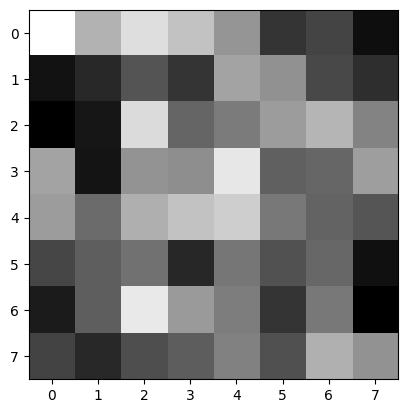

In [ ]:
plt.imshow(out.squeeze().detach().cpu().numpy(), cmap='gray')

In [ ]:
def generate_samples(score_net: torch.nn.Module, nsamples: int, eps: float = 0.001, nsteps: int = 1000) -> torch.Tensor:
    # generate samples using Langevin MCMC
    # x0: (sample_size, nch)
    x0 = torch.rand((nsamples, 1, 8,8)).to(device) * 2 - 1
    for i in range(nsteps):
        z = torch.randn_like(x0)
        x0 = x0 + eps * score_net(x0) + (2 * eps) ** 0.5 * z
    return x0

In [ ]:
out = generate_samples(score_network, nsamples=1, eps=0.01)


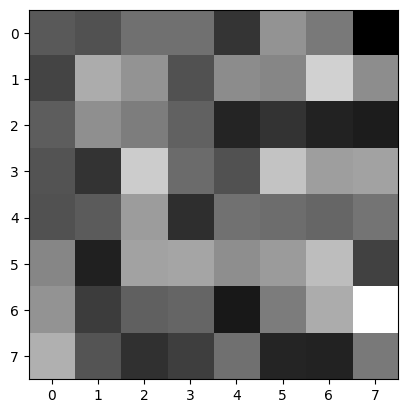

In [ ]:
plt.imshow(out.squeeze().detach().cpu().numpy(), cmap='gray')

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

TypeError: set_ticklabels() takes 2 positional arguments but 3 were given

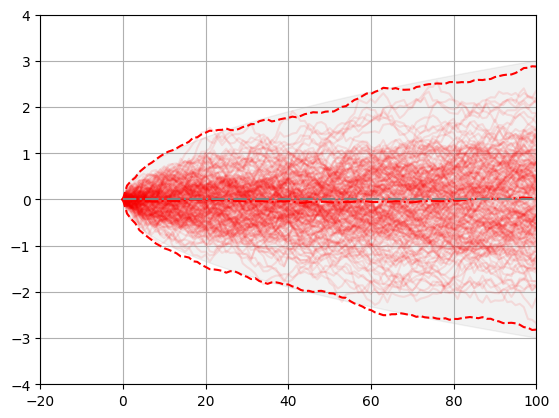

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

T = 1000
dt = 1
MC = 200

mu = 0.0
sigma = 0.1

def drift(x, mu, dt):
	return mu*dt

def diffusion(x, sigma, dt):
	return sigma * dt**0.5*np.random.randn(*x.shape)

# start at zero
x = [np.zeros(MC)]

# simulate Brownian Motion in parallel
for _ in range(T):
	x.append(x[-1]+drift(x[-1], mu, dt) + diffusion(x[-1], sigma, dt))

x = np.array(x)

fig = plt.figure(1)
ax = fig.add_subplot(111)

# plot all the trajectories
_ = ax.plot(x, color='red', alpha=0.1)

# compute the analytical means and variances of the Brownian Motion
analytic_var = np.arange(0,T)*dt*sigma**2
analytic_std = analytic_var**0.5
analytic_mean = np.arange(0,T)*dt*mu

# compute the empirical mean and variance from the sampled Brownian Motion
empiric_var = x.var(axis=1)
empiric_std = empiric_var**0.5
empiric_mean = x.mean(axis=1)

ax.plot(empiric_mean + 3*empiric_std, ls='--', color='red')
ax.plot(empiric_mean - 3*empiric_std, ls='--', color='red')
ax.plot(x.mean(axis=1), ls='-.', color='red')

ax.fill_between(x=np.arange(0,T),y1=analytic_mean+3*analytic_std, y2=analytic_mean+-3*analytic_std, color='gray', alpha=0.1)
plt.plot(analytic_mean, color='gray', ls='-.')

ax.grid(True)
ax.set_xlim(-20,100)
ax.set_ylim(-4,4)
ax.set_xticklabels([],[])
ax.set_yticklabels([],[])
plt.show()